AIM: The following notebook is an attempt to train a model in detecting whether a picture fed to the model depicts a clean or a dirty road. 

APPLICATION: The model can be used to detect whether a road is upto a certain cleanliness standards or not in the city. This can help respective municipal corporation to detect whether a image recieved by their server is showing a clean road or a dirty one, further optimizing thier efforts to keep their city clean.

MOTIVATION: I belong to the Indore, the cleanest city in India. Cleanliness motivates me to further enhance the efforts of my city residents as well as our hard working municipal corporation. 

DISCLAIMER: I would like it to be known this is also an attempt to enhance my skills as a Data Scientist in Deep learning and CNN model development. Although the following efforts are largely mine, I would like to point out that I took assistance from a fellow data scientist's previous work on kaggle.

Data source: https://www.kaggle.com/datasets/faizalkarim/cleandirty-road-classification


In [52]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, accuracy_score
import keras

In [53]:
# Loading paths of the files
meta_file = "/Users/shivanshthakur/Desktop/Data Science/Clean_Road_classification/metadata.csv"
image_path = "/Users/shivanshthakur/Desktop/Data Science/Clean_Road_classification/ImageData"

In [54]:
# Loading Meta data and adding file path as a new column
df = pd.read_csv(meta_file)
df['filepath'] = df['filename'].map(lambda x:  os.path.join(image_path,x))

In [55]:
# mapping dictionary
labelmap = {}
for l in df.label.unique().tolist():
    if l == 1:
        labelmap[l] = 'dirty'
    else:
        labelmap[l] = 'clean'

# seperate list of image that are labelled = dirty
df_dirty = df[df['label'] == 1]
df_dirty.reset_index(drop=True, inplace=True)

# view 
print(f"Found {df.groupby('label').count()['filename'][1]} images that are labelled = dirty and {df.groupby('label').count()['filename'][0]} that are labelled = clean")

Found 124 images that are labelled = dirty and 113 that are labelled = clean


Since the data is balanced we can further pursue with data analysis

In [56]:
df.head(5)

,filename,label,filepath
0,dirty_2.jpg,1,/Users/shivanshthakur/Desktop/Data Science/Cle...
1,clean_36.jpg,0,/Users/shivanshthakur/Desktop/Data Science/Cle...
2,clean_31.jpg,0,/Users/shivanshthakur/Desktop/Data Science/Cle...
3,dirty_69.jpg,1,/Users/shivanshthakur/Desktop/Data Science/Cle...
4,clean_113.jpg,0,/Users/shivanshthakur/Desktop/Data Science/Cle...


Data preprocessing: to split it for testing and training.

In [57]:
# We had to make it to a string value because of ImageDataGenerator
df['label'] = df['label'].astype(str)

In [58]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 
(df_train.shape,df_test.shape)


((189, 3), (48, 3))

Proliferation of Image data


In [59]:
IMG_SHAPE = 256
BATCH_SIZE = 32

traingen=ImageDataGenerator(rescale=1/255.,
                        brightness_range=[0.4,1.4],rotation_range =10 ,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,)


testgen=ImageDataGenerator(rescale=1/255.)

In [60]:
traindata = traingen.flow_from_dataframe(df_train, target_size =(150,150), 
                                         x_col='filepath',y_col='label',
                                         batch_size= BATCH_SIZE, class_mode="binary",
                                          validate_filenames=False )

testdata = testgen.flow_from_dataframe(df_test, target_size =(150,150), 
                                      shuffle = False,
                                      x_col='filepath',y_col='label',
                                      batch_size= BATCH_SIZE, class_mode="binary",
                                       validate_filenames=False )

Found 189 non-validated image filenames belonging to 2 classes.
Found 48 non-validated image filenames belonging to 2 classes.


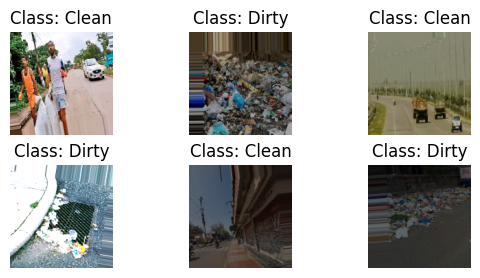

In [61]:
labels=['Clean','Dirty']
samples=traindata.__next__()

images=samples[0]
target=samples[1]

for i in range(6):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [63]:
# Lets create the model
model = Sequential()
 # this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
model.add(Conv2D(32, (3,3), input_shape = (150, 150, 3), activation='relu', strides=1))
 # Max Pooling to reduce the spatial dimensions of the output volume.
model.add(MaxPooling2D())
model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(2,2),strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256,(2,2),strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())
# Flattening the 2D array into a single dimension
model.add(Flatten())
# Adding the dense layer interacting with each neuron of previous layer
model.add(Dense(256,activation="relu"))
# Output layer
model.add(Dense(1,activation='sigmoid'))

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 128)       

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
history = model.fit(traindata, steps_per_epoch = traindata.samples // BATCH_SIZE,
                   epochs = 25, verbose = 1)

Epoch 1/25


2023-03-30 10:57:55.158818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 374ms/step - loss: 0.6981 - accuracy: 0.5312
Epoch 2/25
5/5 [==============================] - 2s 426ms/step - loss: 0.6864 - accuracy: 0.5860
Epoch 3/25
5/5 [==============================] - 2s 429ms/step - loss: 0.6782 - accuracy: 0.5478
Epoch 4/25
5/5 [==============================] - 2s 355ms/step - loss: 0.6705 - accuracy: 0.5987
Epoch 5/25
5/5 [==============================] - 2s 390ms/step - loss: 0.6458 - accuracy: 0.6624
Epoch 6/25
5/5 [==============================] - 2s 350ms/step - loss: 0.5926 - accuracy: 0.7261
Epoch 7/25
5/5 [==============================] - 2s 377ms/step - loss: 0.6312 - accuracy: 0.6624
Epoch 8/25
5/5 [==============================] - 2s 374ms/step - loss: 0.6305 - accuracy: 0.6433
Epoch 9/25
5/5 [==============================] - 2s 364ms/step - loss: 0.5981 - accuracy: 0.6815
Epoch 10/25
5/5 [==============================] - 2s 333ms/step - loss: 0.5794 - accuracy: 0.7070
Epoch 11/25
5/5 [=============

Analyzing the model

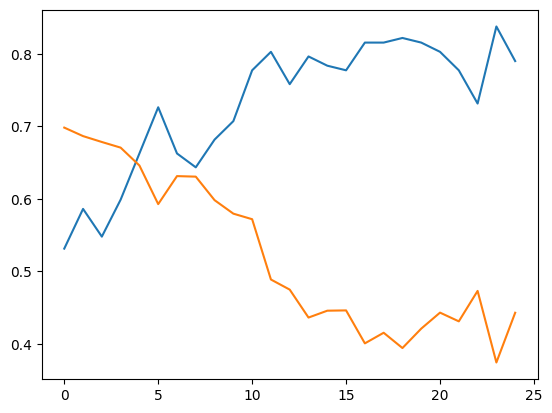

In [67]:
# Reviewing the performance of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [69]:
# Lets test the model
y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred_probs = y_pred.copy()
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

2023-03-30 11:03:38.777413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 225ms/step


In [71]:
print(classification_report(y_test,y_pred,target_names = ['Clean','Dirty']))
print(f"The accuracy is: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

       Clean       1.00      0.70      0.83        27
       Dirty       0.72      1.00      0.84        21

    accuracy                           0.83        48
   macro avg       0.86      0.85      0.83        48
weighted avg       0.88      0.83      0.83        48

The accuracy is: 0.8333333333333334


In [72]:
model.save('Clean_road.h5')